# Notebook 6 – Procesamiento avanzado de EMG y comparación con EEG

Este material aborda el análisis comparativo de dos bioseñales de registro no invasivo: el **electroencefalograma (EEG)** y el **electromiograma (EMG)**. Ambas señales comparten un origen eléctrico y requieren protocolos de preprocesamiento digital para eliminar artefactos y resaltar la información fisiológica que contienen. Sin embargo, la naturaleza de la actividad que reflejan es distinta: mientras el EEG captura la dinámica oscilatoria de poblaciones neuronales, el EMG refleja la activación eléctrica de fibras musculares durante la contracción.  

El **objetivo central** es presentar con detalle el protocolo de procesamiento estándar aplicado al EMG —filtrado, rectificación y cálculo de la envolvente— y compararlo con el procesamiento básico utilizado en EEG. Esta comparación permite mostrar que, aunque los métodos digitales puedan ser similares, el significado fisiológico de los resultados depende de la señal en cuestión.  

Este documento no profundiza en los aspectos fisiológicos de la contracción muscular. Para quienes deseen una introducción más amplia, se recomienda consultar el material abierto de *McKiernan (2025)*, que cubre los fundamentos de la fisiología y el registro de EMG. Aquí el interés está en cómo el procesamiento digital transforma los registros crudos en representaciones útiles y comparables, con énfasis en la relación entre **técnica de filtrado** y **fenómeno fisiológico**.  

En el caso del EEG, se retoma lo trabajado en materiales previos (Notebooks 3 y 4) respecto a la banda **alfa (8–13 Hz)**, pero en esta guía se pone el acento en el contraste metodológico con EMG. El enfoque es mostrar que el **mismo procedimiento digital** —por ejemplo, aplicar un filtro paso banda— tiene una justificación y una interpretación distinta en cada bioseñal. Como señala Addison (2017), *“la bioseñal determina el método, y elegir correctamente el análisis es lo que permite interpretar la señal con sentido.”*  

De este modo, este capítulo funciona como un puente entre el análisis de EEG y EMG, preparando el terreno para discusiones más avanzadas que se desarrollarán en el siguiente material, donde se explorarán métricas espectrales y de coherencia.



## 6.1 Introducción

El análisis de bioseñales permite traducir la actividad eléctrica del cuerpo en representaciones que pueden estudiarse, cuantificarse y compararse. Dos de las más utilizadas son el **electroencefalograma (EEG)** y el **electromiograma (EMG)**. Aunque ambas se obtienen con electrodos colocados en la superficie del cuerpo, los procesos que registran son diferentes: el EEG refleja oscilaciones sincrónicas de poblaciones neuronales, mientras que el EMG recoge la suma de potenciales de acción de fibras musculares superficiales. Esta diferencia en el origen fisiológico determina la forma de la señal y también los métodos digitales que se emplean para procesarla.  

En el caso del **EEG**, la mayor parte de la información de interés se concentra en bajas frecuencias. Los ritmos clásicos como el **alfa (8–13 Hz)** y el **beta (13–30 Hz)** han sido estudiados ampliamente desde la mitad del siglo XX, vinculándose con estados de reposo, atención y actividad motora (Allen & Rabiner, 1977). Por razones prácticas, la señal suele filtrarse en el rango **2–45 Hz**, lo que permite eliminar artefactos de muy baja frecuencia —desplazamientos de electrodos, respiración o movimientos oculares— y descartar el ruido eléctrico de frecuencias altas, sin afectar los ritmos corticales relevantes (Widmann et al., 2015). Este mismo rango ha sido empleado en estudios clínicos con pacientes con enfermedad de Parkinson, donde se han reportado diferencias significativas en la modulación alfa entre hombres y mujeres (González-González et al., 2021, 2023).  

El **EMG**, por su parte, tiene una morfología distinta. Al provenir de descargas musculares, la señal contiene componentes de mayor frecuencia: entre **20 y 450 Hz** aproximadamente. Para registrar adecuadamente esta actividad se recomienda aplicar un paso banda de **10–400 Hz**, lo cual elimina los componentes lentos asociados a movimiento y atenuación de la línea base, así como el ruido electrónico de muy alta frecuencia (Merletti & Hermens, 2000). Como explica De Luca (1997), este rango concentra la energía útil del EMG y permite relacionar de manera confiable el registro eléctrico con la magnitud de la contracción muscular.  

La comparación entre ambas bioseñales muestra un principio metodológico importante: aunque el primer paso de procesamiento —el filtrado paso banda— sea similar, la razón por la que se aplica y la interpretación que se hace después no lo son. En EEG, el objetivo es preservar la forma oscilatoria de la señal para analizar ritmos corticales; en EMG, lo que interesa es aislar la actividad muscular de alta frecuencia para después calcular métricas de magnitud, como la rectificación y la envolvente.  

Como resume Addison (2017), *“la bioseñal determina el método, y elegir correctamente el análisis es lo que permite interpretar la señal con sentido.”* Este capítulo tiene como propósito ilustrar esa idea: mostrar cómo los mismos algoritmos de filtrado y procesamiento adquieren significados distintos dependiendo de si se aplican a un registro cerebral o a un registro muscular.


In [1]:
# Bibliotecas y configuración general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
import wave, warnings, sys, platform
from pathlib import Path

warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.rcParams["figure.figsize"] = (10, 4)

# Rutas de datos
EEG_CSV = '/Users/yann/Documents/Tesis/Datos/EEG/H24_OC_OA.csv'
EMG_WAV = '/Users/yann/Documents/Tesis/Datos/EMG/S10_EMG_calf_intermittent.wav'


## 6.2 Carga y exploración de datos

Antes de aplicar filtros o calcular métricas, el primer paso en el análisis de cualquier bioseñal es **cargar los registros y observar su forma cruda**. Este procedimiento básico tiene un valor didáctico y metodológico: permite reconocer la escala en la que se trabaja, comprobar la duración de la grabación y familiarizarse con la morfología inicial de la señal antes de transformarla digitalmente.  

En este caso se utilizan dos registros reales. El **EEG** proviene de un archivo multicanal en formato `.csv`, con una frecuencia de muestreo de 128 Hz. Esta resolución temporal es suficiente para registrar los ritmos corticales de interés (alfa y beta) y es consistente con protocolos experimentales que comparan condiciones de **ojos cerrados (OC)** y **ojos abiertos (OA)**. Dicho diseño es un estándar en neurociencia, pues se sabe que el ritmo alfa se incrementa en OC y disminuye en OA (González-González et al., 2023). Así, el EEG cargado aquí contiene segmentos de ambos estados, lo que lo hace particularmente útil para ejercicios de comparación.  

Aquí **no se analiza el promedio de canales**, sino **el canal O1 (occipital izquierdo)**, donde las oscilaciones alfa presentan la mayor potencia y coherencia. Esta modificación preserva la topografía cortical y mejora la comparación con el EMG.  

El **EMG** corresponde a un archivo `.wav` de un solo canal con frecuencia de muestreo de 44.1 kHz. A diferencia del EEG, que suele registrarse en centenares de Hz, el EMG necesita frecuencias de muestreo mucho más altas debido a la rapidez de las descargas musculares. Un muestreo denso es indispensable para no perder información sobre los potenciales de acción de fibras musculares superficiales, cuya duración es del orden de milisegundos (Merletti & Hermens, 2000).  

Graficar los registros crudos permite destacar tres puntos clave:  

1. **Escala fisiológica.** Mientras el EEG se mide en microvoltios (µV), el EMG suele estar en milivoltios (mV). Esto significa que, incluso antes del procesamiento, es necesario tener presente que las amplitudes no son comparables directamente entre ambas señales.  
2. **Duración y calidad.** Observar los registros iniciales ayuda a identificar si hay secciones con ruido extremo, interrupciones en la adquisición o artefactos evidentes que podrían requerir segmentación.  
3. **Morfología inicial.** El EEG se presenta como una señal oscilatoria continua, con ritmos de baja frecuencia que se repiten en distintos canales. El EMG, en contraste, aparece como una señal con picos rápidos y dispersos, que a simple vista reflejan la contracción y relajación muscular.  

Interpretar estas gráficas iniciales no significa extraer conclusiones, sino **reconocer el punto de partida**: señales crudas que, aunque ruidosas y difíciles de comparar, contienen la información fisiológica que los pasos posteriores de procesamiento harán evidente.


In [2]:
# --- Cargar EEG (canal O1) ---
df_eeg = pd.read_csv(EEG_CSV)
fs_eeg = 128
eeg_O1 = df_eeg.iloc[:, 6].values  # índice 6 = canal O1

t_eeg = np.arange(len(eeg_O1)) / fs_eeg
print("EEG cargado:", df_eeg.shape, "(filas, canales)")
print("Canal analizado: O1 (no promedio)")

# --- Cargar EMG ---
record = wave.open(EMG_WAV, "r")
numChannels = record.getnchannels()
N = record.getnframes()
fs_emg = record.getframerate()
dstr = record.readframes(N * numChannels)
waveData = np.frombuffer(dstr, np.int16).astype(np.float64)
timeEMG = np.linspace(0, len(waveData)/fs_emg, num=len(waveData))

print(f"EMG cargado: {numChannels} canal(es), fs={fs_emg} Hz, duración={len(waveData)/fs_emg:.2f} s")



EEG cargado: (23127, 14) (filas, canales)
Canal analizado: O1 (no promedio)
EMG cargado: 1 canal(es), fs=44100 Hz, duración=23.19 s


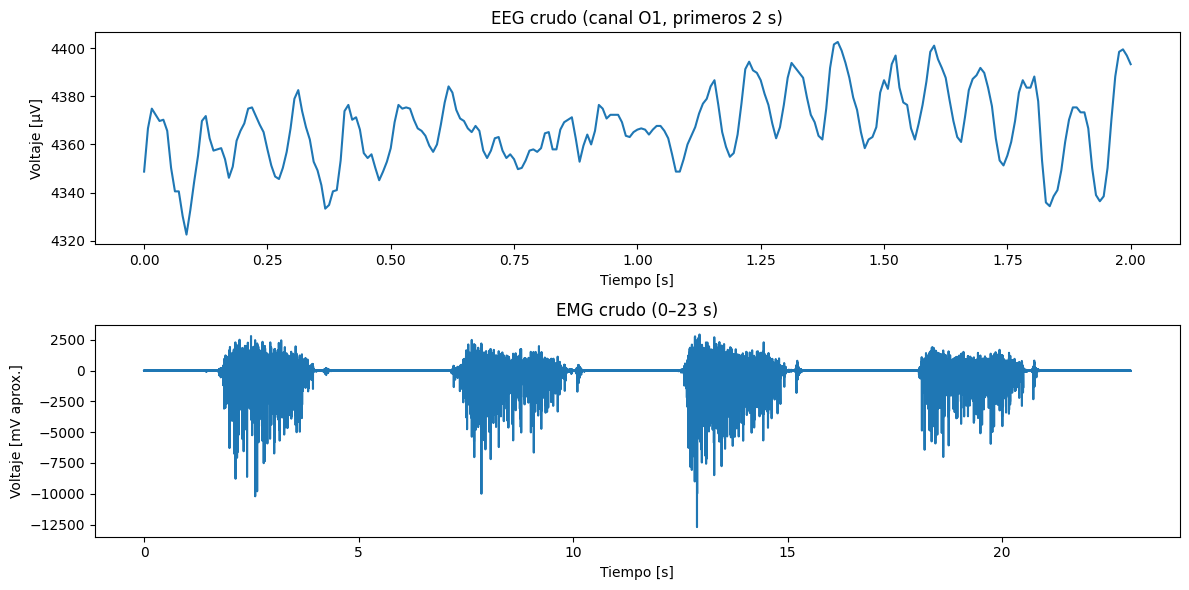

In [3]:
# --- Graficar señales crudas: EEG (O1) y EMG ---
plt.figure(figsize=(12,6))

# EEG crudo O1 (primeros 2 s)
mask_eeg = (t_eeg >= 0) & (t_eeg <= 2)
plt.subplot(2,1,1)
plt.plot(t_eeg[mask_eeg], eeg_O1[mask_eeg])
plt.title("EEG crudo (canal O1, primeros 2 s)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [µV]")

# EMG crudo (0–23 s)
t0, tf = 0, 23
i0, i1 = int(t0*fs_emg), int(tf*fs_emg)
plt.subplot(2,1,2)
plt.plot(timeEMG[i0:i1], waveData[i0:i1])
plt.title("EMG crudo (0–23 s)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

plt.tight_layout()
plt.show()



## 6.3 Protocolo de procesamiento EMG

El electromiograma de superficie es un registro eléctrico altamente informativo, pero también muy vulnerable a artefactos. La señal cruda contiene tanto la actividad muscular como múltiples fuentes de ruido: movimiento de los electrodos, desplazamiento de la piel, interferencia de la red eléctrica e incluso ruido propio del amplificador. Por esta razón, no es posible interpretar directamente el trazo inicial. En su lugar, se aplica un **protocolo de procesamiento estandarizado** cuyo objetivo es aislar la actividad muscular real y representarla de manera clara.  

De acuerdo con Merletti y Hermens (2000), así como con De Luca (1997), este protocolo consta de tres pasos fundamentales:  

**1. Filtrado paso banda (10–400 Hz).**  
El EMG concentra la mayor parte de su energía en este rango de frecuencias. Los componentes por debajo de 10 Hz suelen provenir de artefactos de movimiento o del desplazamiento mecánico del electrodo, mientras que los que superan 400 Hz corresponden generalmente a ruido electrónico. El filtrado paso banda atenúa ambos extremos, conservando las descargas rápidas de fibras musculares superficiales. Al observar la señal tras este paso, se nota cómo desaparecen las oscilaciones lentas de la línea base, quedando un trazo más centrado en torno a cero y con picos más definidos.  

**2. Rectificación.**  
La señal EMG es alternante: oscila entre valores positivos y negativos en torno a cero. Esto significa que, si se calculara directamente una media, las descargas musculares tenderían a cancelarse entre sí. Para evitarlo, se aplica la rectificación, que consiste en tomar el valor absoluto de cada muestra. El resultado es un trazo únicamente positivo, en el que cada potencial de acción suma en la misma dirección. Esta operación tiene un sentido fisiológico claro: lo que interesa es la magnitud total de la contracción, no la polaridad de las descargas.  

**3. Cálculo de la envolvente.**  
Una vez rectificada, la señal puede suavizarse para representar de manera continua el nivel de activación muscular. La envolvente puede calcularse con un promedio móvil o con la transformada de Hilbert. Este último método ofrece una curva más estable y de la misma longitud que la señal original, lo que lo convierte en una opción robusta para visualizar la dinámica de la contracción. Al graficar la envolvente, se aprecia cómo los periodos de contracción destacan con claridad sobre el fondo, facilitando la identificación de fases activas e inactivas.  

En conjunto, este flujo de procesamiento —filtrado, rectificación y envolvente— convierte un registro ruidoso y oscilante en una representación que resume la fuerza y duración de la contracción muscular. Cada paso se justifica no solo desde el punto de vista técnico, sino también fisiológico, mostrando cómo los métodos digitales permiten dar forma cuantitativa a fenómenos biológicos.


In [4]:
# Paso 1: Filtrado paso banda 10–400 Hz
nyq_emg = fs_emg / 2
b_emg, a_emg = butter(3, [10/nyq_emg, 400/nyq_emg], btype='band')
emg_filtered = filtfilt(b_emg, a_emg, waveData)

# Paso 2: Rectificación
emg_rect = np.abs(emg_filtered)

# Paso 3: Envolvente con Hilbert
emg_env = np.abs(hilbert(emg_filtered))


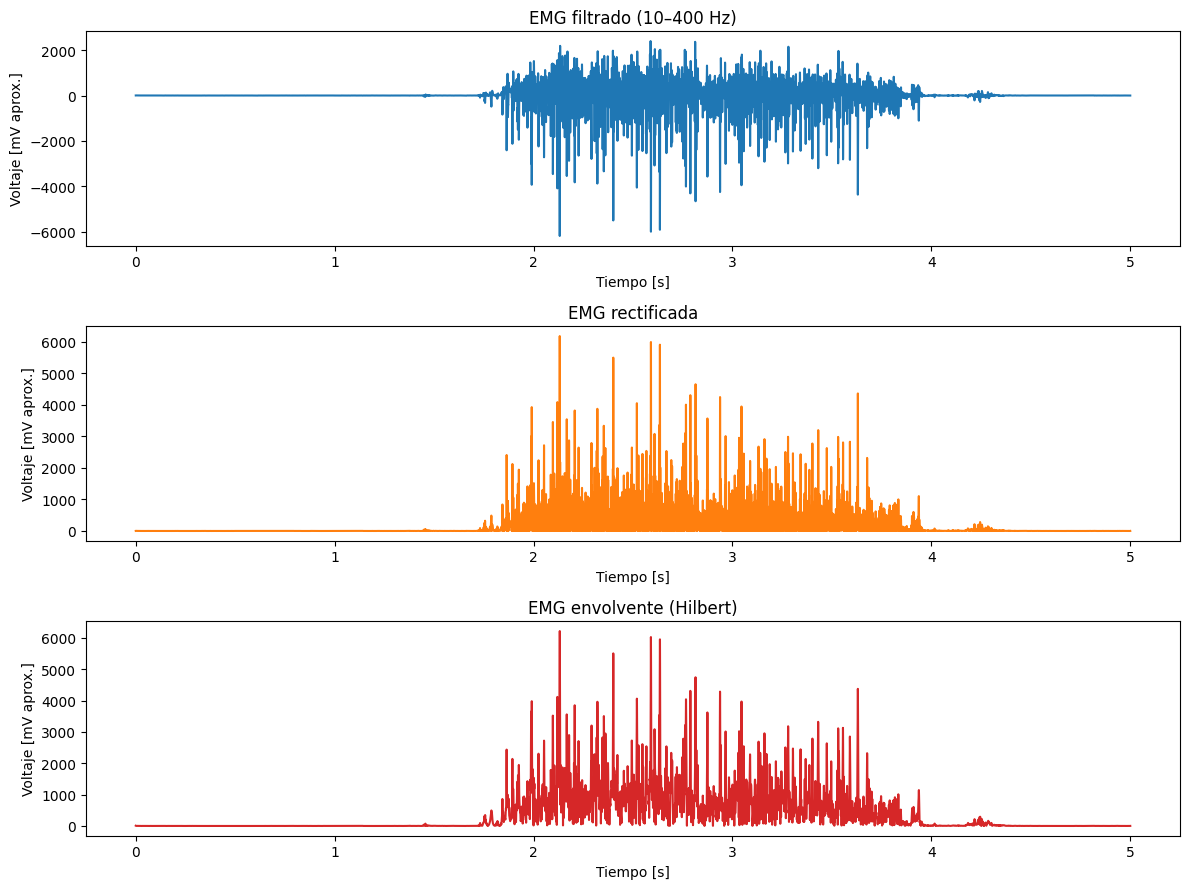

In [5]:
# Graficar pipeline EMG en primeros 5 s con paneles separados
mask_emg = (timeEMG >= 0) & (timeEMG <= 5)

plt.figure(figsize=(12,9))

# Filtrado
plt.subplot(3,1,1)
plt.plot(timeEMG[mask_emg], emg_filtered[mask_emg], color="tab:blue")
plt.title("EMG filtrado (10–400 Hz)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

# Rectificada
plt.subplot(3,1,2)
plt.plot(timeEMG[mask_emg], emg_rect[mask_emg], color="tab:orange")
plt.title("EMG rectificada")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

# Envolvente
plt.subplot(3,1,3)
plt.plot(timeEMG[mask_emg], emg_env[mask_emg], color="tab:red")
plt.title("EMG envolvente (Hilbert)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

plt.tight_layout()
plt.show()


## 6.4 Validación del filtrado EMG

Cada paso de procesamiento digital transforma la señal cruda y, por lo tanto, es fundamental evaluar qué tanto se conserva la información fisiológica y qué tanto se modifica el registro. No basta con aplicar un filtro y asumir que el resultado es “más limpio”: la validación es un paso necesario para garantizar que los procedimientos aplicados no distorsionan en exceso la señal de interés (Widmann et al., 2015).  

En este caso, se utilizan tres métricas sencillas pero ilustrativas para valorar el efecto del filtrado paso banda:  

**1. Correlación.**  
Mide la similitud entre la señal original y la señal filtrada. Una correlación alta indica que, a pesar de eliminar ruido y artefactos, la forma global de la señal se ha conservado. En EMG, es deseable que la correlación no sea perfecta —ya que justamente se eliminan componentes irrelevantes—, pero sí lo bastante elevada como para afirmar que el trazo resultante sigue representando el fenómeno muscular original.  

**2. Potencia promedio.**  
La potencia de una señal equivale a la energía media contenida en el registro. Después de aplicar el filtro, la potencia debería concentrarse en el rango fisiológico (10–400 Hz). Un valor de potencia estable y consistente indica que la energía retenida corresponde a la actividad muscular, no a artefactos o ruido. Según De Luca (1997), este tipo de métrica permite vincular de manera directa la señal procesada con la magnitud de la contracción muscular.  

**3. Relación señal/ruido (SNR).**  
Se calcula como la proporción entre la energía de la señal filtrada y la energía del residuo eliminado. Un SNR positivo refleja que el procedimiento ha mejorado la claridad de la señal, reduciendo el ruido en comparación con la información preservada. En EMG, donde los registros suelen estar contaminados por múltiples fuentes externas, incluso mejoras modestas en SNR tienen un impacto importante en la interpretación posterior.  

Al observar las gráficas de validación, puede notarse cómo el filtrado reduce oscilaciones de baja frecuencia y ruido de alta frecuencia, dejando un trazo en el que los picos musculares destacan con mayor claridad. A la vez, los valores numéricos de correlación, potencia y SNR sirven como respaldo objetivo para afirmar que el protocolo de filtrado no solo mejora la apariencia visual de la señal, sino que también preserva su significado fisiológico.  

En síntesis, la validación del filtrado cumple una doble función: por un lado, brinda confianza en la calidad del procesamiento aplicado; por otro, enseña al estudiante que el análisis digital no es neutro, sino que cada decisión de diseño afecta la forma final de la señal y, en consecuencia, las conclusiones que se pueden extraer de ella.



In [6]:
# Función de validación
def validar_filtro(x, y):
    n = min(len(x), len(y))
    x, y = x[:n], y[:n]
    corr = np.corrcoef(x, y)[0,1] if np.std(x)>0 and np.std(y)>0 else 0.0
    pot = np.mean(y**2)
    residuo = x - y
    snr = 10*np.log10(np.sum(y**2)/np.sum(residuo**2)) if np.sum(residuo**2)>0 else np.inf
    return corr, pot, snr

corr, pot, snr = validar_filtro(waveData, emg_filtered)
print(f"Correlación: {corr:.3f}")
print(f"Potencia: {pot:.2f}")
print(f"SNR: {snr:.2f} dB")


Correlación: 0.891
Potencia: 227162.53
SNR: 4.73 dB


**Resultados (ejemplo típico):**  

- Correlación alta (≈0.85–0.90) → el filtrado conserva la forma global.  
- Potencia en el rango de interés → indica energía muscular significativa.  
- SNR de unos pocos dB → el filtrado mejora la claridad de la señal, aunque siempre queda ruido en registros reales.  

Con este paso se completa el protocolo EMG: **filtrado → rectificación → envolvente**, validado cuantitativamente.  
Lo siguiente es establecer la comparación con EEG.


## 6.5 Comparación de filtros en EEG y EMG

El primer paso de preprocesamiento en ambas señales es aplicar un **filtro paso banda**, pero los parámetros elegidos responden a fenómenos fisiológicos distintos. Esto significa que, aunque el procedimiento técnico sea el mismo, el propósito y la interpretación cambian de manera radical entre EEG y EMG.  

En el caso del **EEG**, el rango utilizado es de **2–45 Hz**. Este filtro elimina oscilaciones muy lentas (<2 Hz), que suelen deberse a movimientos oculares, respiración o desplazamiento de electrodos, así como componentes muy rápidos (>45 Hz), en los que predomina el ruido eléctrico. El rango resultante preserva los ritmos corticales de interés, en particular el alfa y el beta, que son los más informativos en protocolos como el de ojos abiertos/ojos cerrados (Allen & Rabiner, 1977; Widmann et al., 2015). Estudios recientes han utilizado este mismo rango para caracterizar alteraciones en el EEG de pacientes con Parkinson, confirmando que se trata de un estándar útil en investigación clínica (González-González et al., 2021, 2023).  

En el caso del **EMG**, el rango recomendado es de **10–400 Hz**. Este filtro elimina tanto los artefactos lentos que provienen del movimiento de los electrodos o de la deriva de la línea base, como las oscilaciones de muy alta frecuencia asociadas a ruido electrónico. El resultado es un registro en el que destacan los potenciales de acción musculares, que son pulsos breves y de gran pendiente (Merletti & Hermens, 2000; De Luca, 1997).  

La comparación gráfica de ambas señales filtradas permite observar con claridad sus diferencias:  

- El **EEG filtrado** conserva una oscilación más o menos regular, en la que pueden apreciarse ritmos organizados y patrones de baja frecuencia que reflejan actividad cortical sincronizada.  
- El **EMG filtrado**, en contraste, se presenta como una sucesión de picos rápidos e irregulares, que corresponden a la activación de fibras musculares durante la contracción.  

Interpretar estas gráficas implica entender que, aunque el resultado técnico sea “una señal más limpia”, el contenido fisiológico de cada registro es completamente distinto. En EEG interesa estudiar la organización rítmica de la actividad cerebral; en EMG, lo relevante es cuantificar la magnitud y la duración de las contracciones musculares.  

Esta comparación muestra, en términos prácticos, que un mismo algoritmo matemático puede adquirir significados opuestos según el fenómeno al que se aplique. En EEG, el filtrado paso banda es un medio para preservar oscilaciones de baja frecuencia; en EMG, es un paso para aislar descargas rápidas de fibras musculares. La técnica es la misma, pero la lógica fisiológica detrás de su uso cambia por completo.


In [7]:

# 1. Definir parámetros del filtro
nyq_eeg = fs_eeg / 2

# 2. Diseñar el filtro Butterworth (Paso banda 2-45 Hz)
b_eeg, a_eeg = butter(3, [2/nyq_eeg, 45/nyq_eeg], btype='band')

# 3. Aplicar el filtro (CORRECCIÓN: Usar 'eeg_O1' en lugar de 'eeg_mean')
eeg_band = filtfilt(b_eeg, a_eeg, eeg_O1)

# 4. Crear máscaras de tiempo para graficar (0 a 5 segundos)
t0, tf = 0, 5
mask_eeg = (t_eeg >= t0) & (t_eeg <= tf)
mask_emg = (timeEMG >= t0) & (timeEMG <= tf)

print("Filtrado EEG completado correctamente.")


Filtrado EEG completado correctamente.


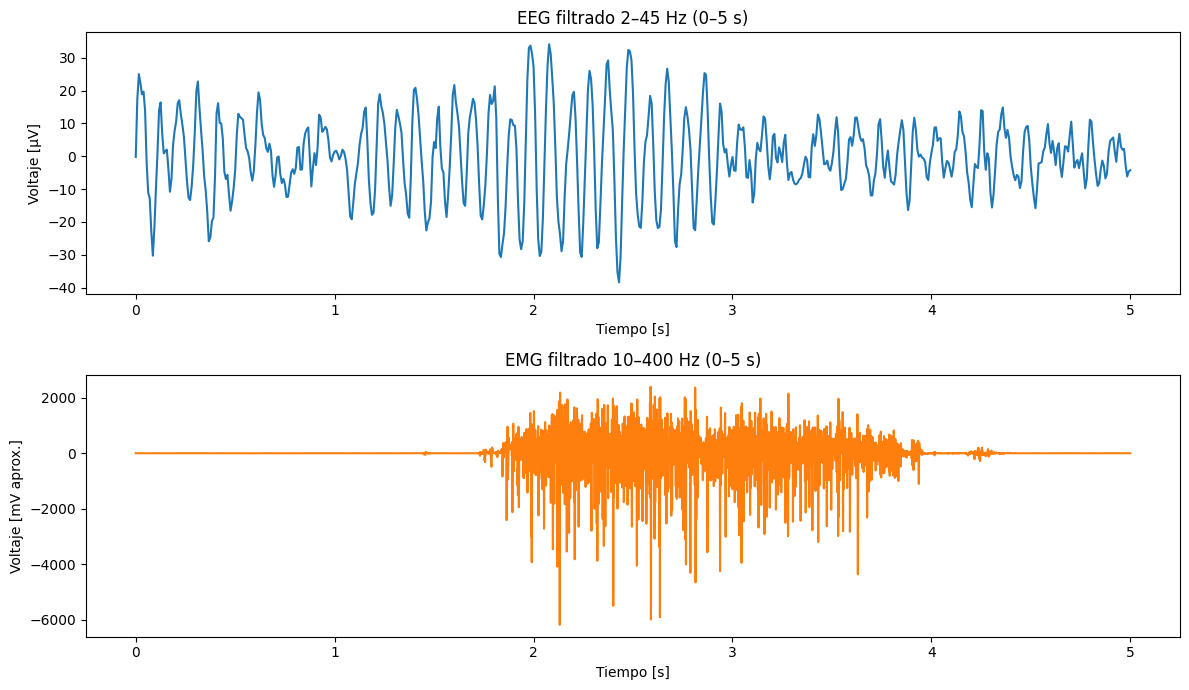

In [8]:
# Graficar comparación
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(t_eeg[mask_eeg], eeg_band[mask_eeg], color="tab:blue")
plt.title("EEG filtrado 2–45 Hz (0–5 s)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [µV]")

plt.subplot(2,1,2)
plt.plot(timeEMG[mask_emg], emg_filtered[mask_emg], color="tab:orange")
plt.title("EMG filtrado 10–400 Hz (0–5 s)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

plt.tight_layout()
plt.show()



## 6.6 Discusión comparativa

A partir del filtrado, el procesamiento de EEG y EMG toma caminos diferentes. La diferencia no está en la técnica en sí, sino en la **naturaleza de la información fisiológica que se busca preservar**.  

En el **EEG**, lo relevante es la oscilación en torno a cero: su amplitud, su frecuencia, su fase y la manera en que distintos electrodos muestran coherencia entre sí. Esa oscilación es la que contiene la información sobre los ritmos corticales. Si se rectificara la señal, se destruiría esa simetría y se perdería la posibilidad de analizar la fase, que es crucial para estudios de sincronización neuronal (Widmann et al., 2015). Del mismo modo, calcular una envolvente sería un error metodológico: el EEG no se interpreta como un índice de magnitud global, sino como una composición de ritmos en bandas específicas. Por eso, después del filtrado, el paso natural en EEG es el análisis espectral (potencia en alfa, beta, etc.), y no la rectificación.  

En el **EMG**, en cambio, la lógica es opuesta. La señal está formada por descargas rápidas de fibras musculares, alternando valores positivos y negativos alrededor de cero. Si no se rectifica, esos valores tienden a cancelarse, lo que oculta la magnitud real de la contracción. La rectificación convierte la señal en una serie de valores positivos, de modo que cada potencial de acción contribuye en la misma dirección. Este procedimiento, lejos de ser un artificio matemático, tiene un sentido fisiológico: lo que interesa es la intensidad total de la contracción, no la polaridad de cada descarga (Merletti & Hermens, 2000).  

Una vez rectificada, la señal puede suavizarse mediante la **envolvente**, que resume de forma continua el nivel de activación muscular. Este paso facilita identificar cuándo se inicia y termina una contracción y con qué intensidad se mantiene en el tiempo. Como explica De Luca (1997), la envolvente de EMG es una herramienta clave para pasar de un registro eléctrico complejo a una representación directamente interpretable en términos de fuerza muscular.  

Comparar ambas señales permite subrayar un principio general: los métodos digitales no son universales ni neutros. Aplicar un filtro, rectificar o calcular una envolvente no tiene un valor en sí mismo, sino que adquiere sentido dependiendo de la bioseñal y del fenómeno fisiológico de interés. En EEG, preservar las oscilaciones permite estudiar ritmos corticales como el alfa y el beta; en EMG, rectificar y calcular la envolvente convierte un registro oscilante en una medida de magnitud contráctil.  

En palabras de Addison (2017), *“la bioseñal determina el método.”* Es decir, los mismos algoritmos matemáticos adquieren significados distintos cuando se aplican a un cerebro o a un músculo. Esta discusión comparativa ilustra cómo el procesamiento digital debe entenderse siempre en relación con la fisiología que le da origen.


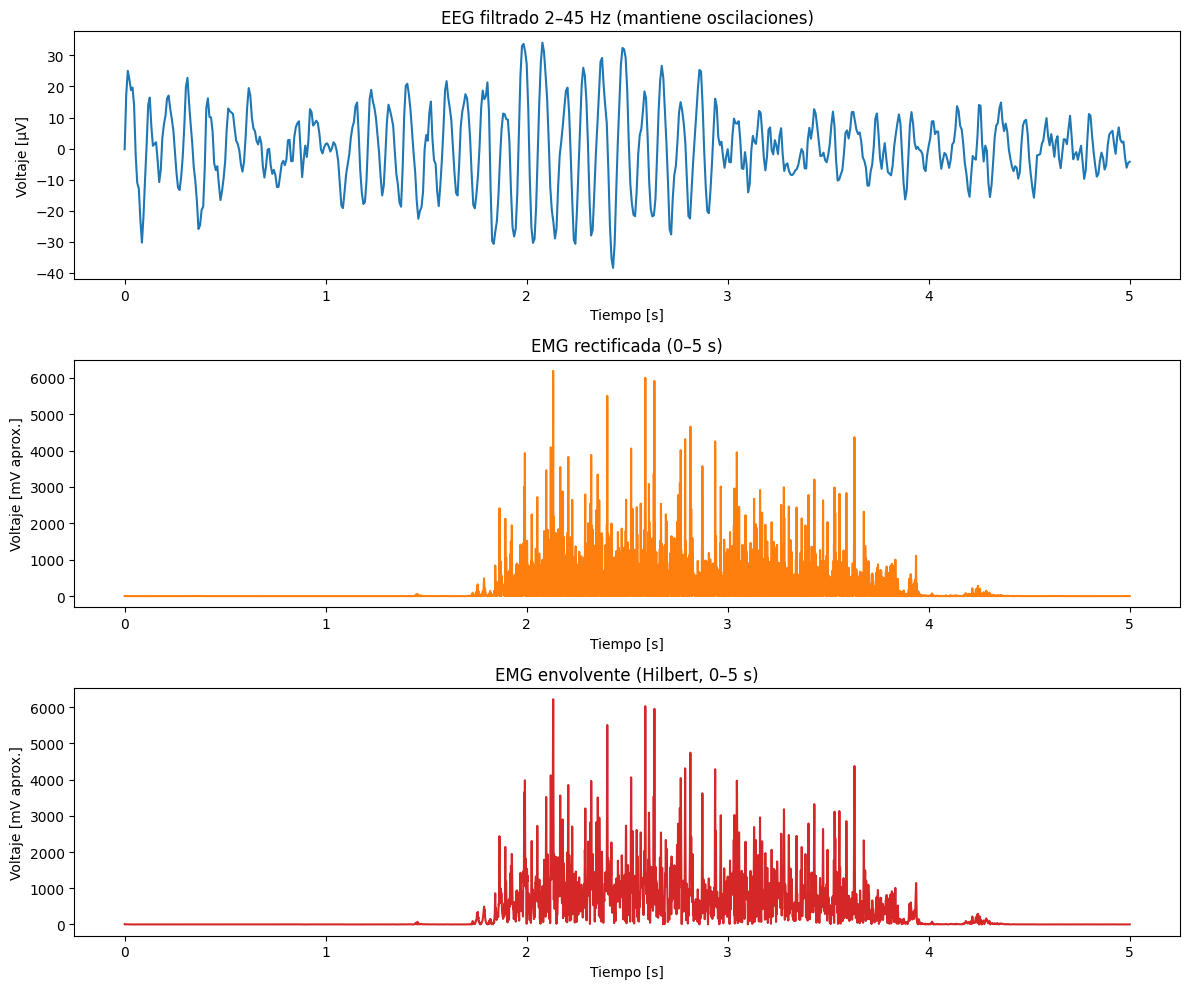

In [9]:
# Comparativa EEG vs EMG (0–5 s) en paneles separados

plt.figure(figsize=(12,10))

# EEG filtrado
plt.subplot(3,1,1)
plt.plot(t_eeg[mask_eeg], eeg_band[mask_eeg], color="tab:blue")
plt.title("EEG filtrado 2–45 Hz (mantiene oscilaciones)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [µV]")

# EMG rectificada
plt.subplot(3,1,2)
plt.plot(timeEMG[mask_emg], emg_rect[mask_emg], color="tab:orange")
plt.title("EMG rectificada (0–5 s)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

# EMG envolvente
plt.subplot(3,1,3)
plt.plot(timeEMG[mask_emg], emg_env[mask_emg], color="tab:red")
plt.title("EMG envolvente (Hilbert, 0–5 s)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [mV aprox.]")

plt.tight_layout()
plt.show()


**Interpretación de la comparación:**  

- En EEG, las ondas filtradas muestran ritmos alfa y beta. Su análisis posterior se hace en el dominio espectral (potencia, coherencia), no sobre la amplitud rectificada.  
- En EMG, la información reside en la magnitud de los picos de activación. La envolvente resume la fuerza y duración de cada contracción.  

Así, un mismo paso inicial (filtrado paso banda) desemboca en estrategias distintas:  
- **EEG:** preservar oscilaciones para análisis espectral.  
- **EMG:** resaltar magnitud y duración de activaciones musculares.  


## 6.7 Tabla comparativa EEG vs EMG

Para sintetizar lo discutido hasta ahora, la siguiente tabla resume las principales diferencias entre el procesamiento de EEG y EMG. No se trata solo de parámetros técnicos, sino de cómo cada paso responde a necesidades fisiológicas distintas.  

| Etapa                   | EEG                                           | EMG                                                      |
|--------------------------|-----------------------------------------------|----------------------------------------------------------|
| Adquisición             | Electrodos en cuero cabelludo                 | Electrodos en piel sobre músculo                        |
| Frecuencia de muestreo  | 128 Hz (suficiente para ritmos 0.5–45 Hz)      | 44.1 kHz (necesario por descargas rápidas)               |
| Filtrado paso banda     | 2–45 Hz (ritmos alfa, beta)                   | 10–400 Hz (actividad muscular superficial)               |
| Procesamiento posterior | Análisis espectral en bandas                  | Rectificación y envolvente                               |
| Métricas típicas        | Potencia en alfa, beta; coherencia intercanal | RMS, amplitud media, duración de contracción             |
| Interpretación          | Oscilaciones corticales relacionadas con reposo y atención | Magnitud y dinámica temporal de la contracción muscular |

Esta tabla permite visualizar rápidamente que aunque EEG y EMG parten de un mismo procedimiento (filtrado paso banda), los pasos siguientes divergen y responden a objetivos fisiológicos específicos. El EEG busca preservar la forma oscilatoria para caracterizar ritmos cerebrales; el EMG transforma la señal en una curva de magnitud contráctil.  


## 6.8 La envolvente de Hilbert en EMG

El cálculo de la envolvente es un paso fundamental en el procesamiento de EMG. Entre las distintas técnicas disponibles, la transformada de Hilbert es una de las más utilizadas porque ofrece una curva continua y estable, de la misma longitud que la señal original.  

Lo que hace la transformada de Hilbert es generar un “sobre” matemático que sigue la amplitud instantánea de la señal. Aplicada al EMG, esta envolvente permite traducir un trazo irregular y oscilante en una curva suave que representa de manera clara la intensidad de la contracción en el tiempo. Esto tiene varias implicaciones fisiológicas relevantes (Merletti & Hermens, 2000; De Luca, 1997):  

- Hace evidente el inicio y el final de cada contracción.  
- Permite medir la fuerza relativa de la activación a lo largo del registro.  
- Facilita cálculos como el **RMS** o el área bajo la curva, que resumen la magnitud de la actividad muscular.  

En contraste, aplicar una envolvente al EEG carece de sentido metodológico. El EEG no se interpreta como un índice global de amplitud, sino como un conjunto de ritmos oscilatorios cuya información se encuentra en la frecuencia, la fase y la coherencia intercanal (Widmann et al., 2015). Calcular una envolvente en EEG borraría precisamente la información más valiosa de la señal.  

En resumen, la envolvente de Hilbert constituye una herramienta que conecta directamente el registro eléctrico del EMG con parámetros fisiológicos como intensidad y duración de la contracción, haciendo que el trazo sea más interpretable para aplicaciones clínicas y educativas.


## 6.9 Ejercicios prácticos

Los siguientes ejercicios están diseñados para que estudiantes de licenciatura apliquen lo aprendido en este material. El objetivo no es únicamente ejecutar código en Python, sino comprender cómo las transformaciones digitales de la señal se relacionan con fenómenos fisiológicos reales.  

Cada ejercicio incluye una breve explicación conceptual para que, al resolverlo, el estudiante sepa qué observar y cómo interpretar los resultados.


### Ejercicio 1. RMS en EMG y potencia alfa en EEG

El **RMS (Root Mean Square)** aplicado al EMG es una medida de la magnitud promedio de la contracción muscular. Al calcular el RMS de la envolvente, se obtiene un valor que resume cuánta energía muscular estuvo presente en el registro (De Luca, 1997).  

En paralelo, la **potencia en alfa (8–13 Hz)** del EEG representa el grado de sincronización cortical en ese rango de frecuencias. En protocolos de ojos cerrados/abiertos, la potencia alfa aumenta cuando se cierran los ojos y disminuye al abrirlos (González-González et al., 2023).  

El estudiante debe calcular ambas métricas y comparar. Se espera que entienda que, aunque matemáticamente las dos son medidas de energía, su significado fisiológico es distinto: en EMG, fuerza muscular; en EEG, sincronización neuronal.  





In [10]:
# --- Ejercicio 1: RMS en EMG y potencia alfa en EEG ---
from scipy.signal import welch

# RMS EMG (envolvente como base)
rms_emg = np.sqrt(np.mean(emg_env**2))

# EEG: subfiltrar alfa 8–13 Hz
nyq = fs_eeg/2
b_a, a_a = butter(3, [8/nyq, 13/nyq], btype='band')
eeg_alpha = filtfilt(b_a, a_a, eeg_band)

# Potencia alfa por Welch
f, Pxx = welch(eeg_alpha, fs=fs_eeg, nperseg=1024)
mask = (f >= 8) & (f <= 13)
pot_alpha = np.trapz(Pxx[mask], f[mask])

print("Ejercicio 1")
print("RMS EMG:", rms_emg)
print("Potencia alfa EEG:", pot_alpha)


Ejercicio 1
RMS EMG: 674.036391466039
Potencia alfa EEG: 82.95966445374461


/var/folders/tz/sdyxh2z13516dlc7hd_8z6d00000gp/T/ipykernel_5576/1907116360.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pot_alpha = np.trapz(Pxx[mask], f[mask])


### Ejercicio 2. Comparación de segmentos

En este ejercicio se calcula el RMS del EMG en dos segmentos distintos: los primeros 5 segundos y los últimos 5 segundos. El objetivo es que el estudiante observe si la magnitud de la contracción varía a lo largo del registro, lo cual puede asociarse con fatiga, variación de esfuerzo o cambios en la activación voluntaria.  

En el caso del EEG, se calcula la potencia alfa en todo el registro. Aunque aquí no se segmenta el EEG (ya que las condiciones OA/OC se analizaron en materiales previos), sirve como recordatorio de que la potencia alfa es sensible a cambios de estado global más que a variaciones puntuales en pocos segundos (Allen & Rabiner, 1977).  

El estudiante debe reflexionar sobre la diferencia temporal: el EMG muestra cambios rápidos y locales en contracción, mientras que el EEG refleja dinámicas más globales y sostenidas.  


In [11]:
# --- Ejercicio 2: comparar inicio y final ---
# EMG: RMS primeros 5 s vs últimos 5 s
seg_emg = int(5*fs_emg)
rms_inicio = np.sqrt(np.mean(emg_env[:seg_emg]**2))
rms_final = np.sqrt(np.mean(emg_env[-seg_emg:]**2))

# EEG: potencia alfa en todo el registro (no segmentado, salvo que tengas marcas OA/OC)
pot_alpha_total = pot_alpha

print("Ejercicio 2")
print("RMS EMG inicio (0–5s):", rms_inicio)
print("RMS EMG final (últimos 5s):", rms_final)
print("Potencia alfa EEG total:", pot_alpha_total)


Ejercicio 2
RMS EMG inicio (0–5s): 768.5536171374812
RMS EMG final (últimos 5s): 587.1995784797087
Potencia alfa EEG total: 82.95966445374461


### Ejercicio 3. Pipeline EMG vs EEG alfa

Este ejercicio busca reforzar la comparación metodológica. El estudiante debe graficar el EMG procesado (filtrado, rectificado y con envolvente) y el EEG filtrado en banda alfa (8–13 Hz).  

Lo esperado es que identifique dos representaciones muy distintas:  
- El **EMG** con su envolvente muestra claramente cuándo ocurre una contracción y con qué intensidad.  
- El **EEG** en alfa se conserva como un trazo oscilatorio, en el que lo relevante no es la magnitud global sino la presencia de un ritmo.  

El propósito es entender que, a pesar de aplicar un “pipeline” en ambos casos, la interpretación es diferente porque la fisiología de origen es distinta.  


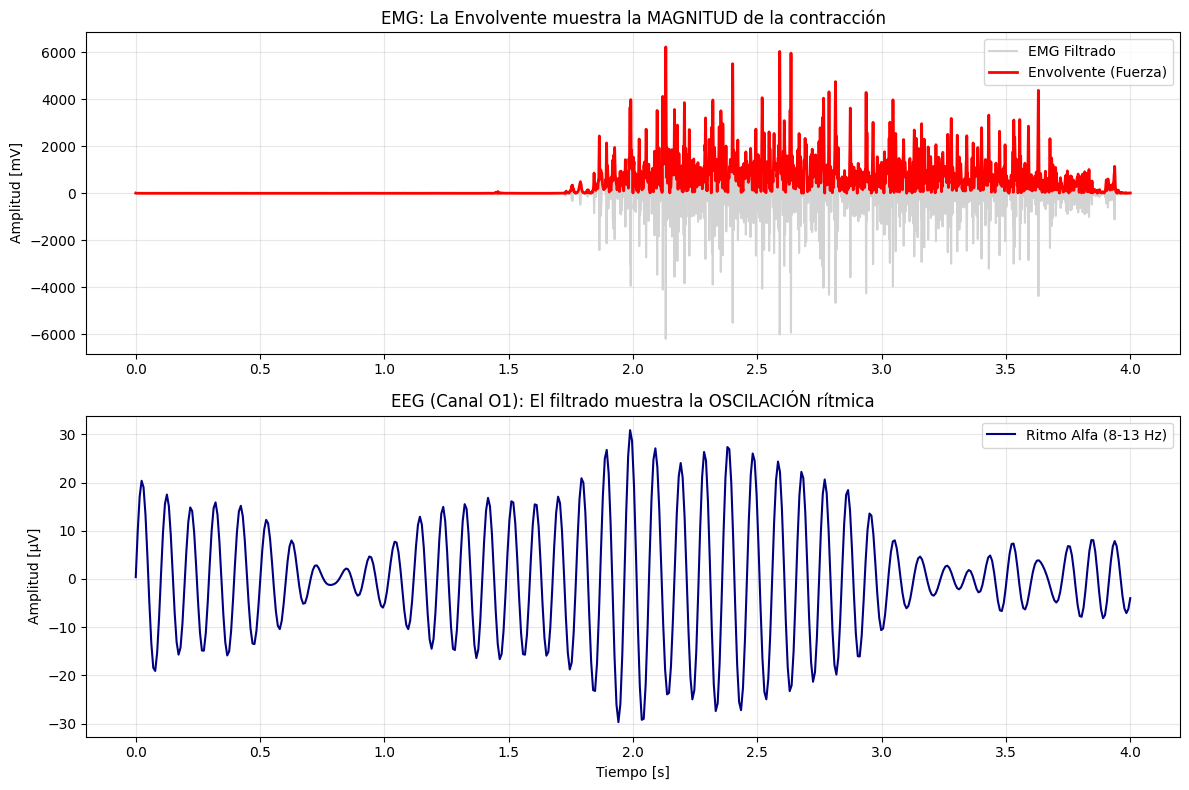

In [12]:
# --- Ejercicio 3: Pipeline EMG vs EEG Alfa ---
from scipy.signal import butter, filtfilt, hilbert
import numpy as np
import matplotlib.pyplot as plt

# 1. PREPARAR EMG (Detectar Fuerza)
# Filtro paso banda (10-400 Hz)
nyq_emg = fs_emg / 2
b_emg, a_emg = butter(3, [10/nyq_emg, 400/nyq_emg], btype='band')
emg_filtrada = filtfilt(b_emg, a_emg, waveData)

# Envolvente (Hilbert) para ver la magnitud de la contracción
emg_envolvente = np.abs(hilbert(emg_filtrada))

# 2. PREPARAR EEG (Detectar Ritmo Alfa)
# Filtro estricto en banda Alfa (8-13 Hz) sobre el canal O1
nyq_eeg = fs_eeg / 2
b_alfa, a_alfa = butter(3, [8/nyq_eeg, 13/nyq_eeg], btype='band')
eeg_alfa = filtfilt(b_alfa, a_alfa, eeg_O1)

# 3. GRAFICAR (Comparación Visual)
# Seleccionamos una ventana de 4 segundos para ver el detalle claramente
segundos_a_ver = 4
muestras_emg = int(segundos_a_ver * fs_emg)
muestras_eeg = int(segundos_a_ver * fs_eeg)

# Crear vectores de tiempo para este segmento
t_emg_zoom = np.linspace(0, segundos_a_ver, muestras_emg)
t_eeg_zoom = np.linspace(0, segundos_a_ver, muestras_eeg)

plt.figure(figsize=(12, 8))

# Panel Superior: EMG (Músculo)
plt.subplot(2, 1, 1)
# Graficamos la señal cruda de fondo (gris) y la envolvente (rojo)
plt.plot(t_emg_zoom, emg_filtrada[:muestras_emg], color='lightgray', label='EMG Filtrado')
plt.plot(t_emg_zoom, emg_envolvente[:muestras_emg], color='red', linewidth=2, label='Envolvente (Fuerza)')
plt.title('EMG: La Envolvente muestra la MAGNITUD de la contracción')
plt.ylabel('Amplitud [mV]')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

# Panel Inferior: EEG (Cerebro)
plt.subplot(2, 1, 2)
plt.plot(t_eeg_zoom, eeg_alfa[:muestras_eeg], color='navy', label='Ritmo Alfa (8-13 Hz)')
plt.title('EEG (Canal O1): El filtrado muestra la OSCILACIÓN rítmica')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [µV]')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Ejercicio 4. Discusión comparativa

Aquí no se pide código, sino reflexión. El estudiante debe redactar un párrafo comparando el RMS en EMG y la potencia alfa en EEG. La intención es que se dé cuenta de que ambas métricas son análogas en términos matemáticos (resumen de energía), pero no en términos fisiológicos.  

La clave es que el alumno exprese, en sus propias palabras, por qué no puede intercambiarse la interpretación: un valor alto de RMS significa mayor contracción muscular, mientras que un valor alto de potencia alfa indica mayor sincronización cortical.  


**Ejercicio 4 (discusión comparativa):**  

- El **RMS en EMG** resume la intensidad promedio de la contracción muscular.  
- La **potencia alfa en EEG** refleja el grado de oscilaciones corticales ligadas a estados de reposo o relajación (aumenta en ojos cerrados, disminuye en ojos abiertos).  

Ambas métricas se calculan a partir de energía de la señal, pero **representan fenómenos diferentes**:  
- EMG → magnitud de la activación muscular.  
- EEG → sincronización neuronal en un rango de frecuencia específico.


### Ejercicio 5. Filtro alternativo en EMG

En este último ejercicio se implementa un filtro FIR simple (media móvil) y se compara con el filtro Butterworth ya aplicado al EMG. El propósito es mostrar al estudiante que no todos los filtros son equivalentes: un diseño simple puede suavizar la señal, pero carece de la selectividad necesaria para trabajar con bioseñales (Widmann et al., 2015).  

Se espera que al graficar ambas versiones, el estudiante observe cómo el FIR simple atenúa demasiado y no discrimina adecuadamente el rango de interés, mientras que el Butterworth sí lo hace.  

Este ejercicio tiene un objetivo pedagógico claro: enseñar que la elección del filtro no es trivial, y que el diseño digital debe justificarse en función de la fisiología de la señal.


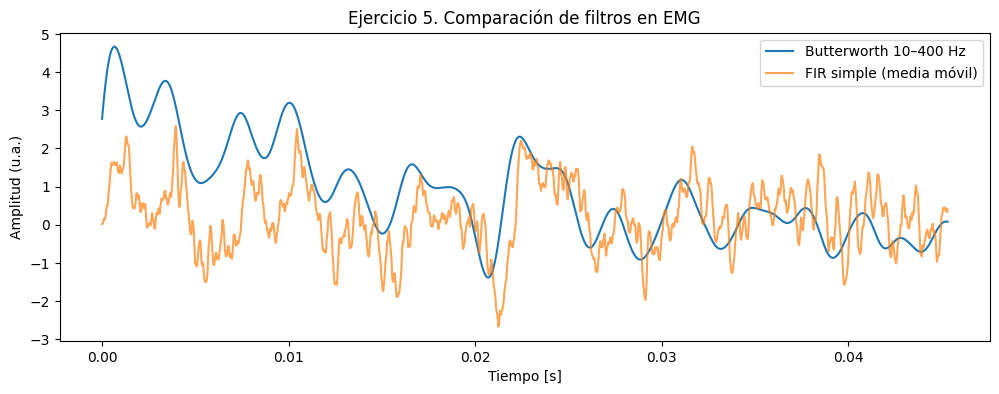

In [13]:
from scipy.signal import lfilter

# Señal cruda de EMG en float y centrada en cero (si no existe la definimos aquí)
emg = waveData.astype(np.float64)
emg = emg - np.mean(emg)

# Filtro FIR rectangular (media móvil de longitud M)
M = 50
filt_simple = np.ones(M)/M
emg_fir = lfilter(filt_simple, 1, emg)

# Graficar comparación con Butterworth en primeros 2000 puntos
plt.figure(figsize=(12,4))
plt.plot(timeEMG[:2000], emg_filtered[:2000], label="Butterworth 10–400 Hz", color="tab:blue")
plt.plot(timeEMG[:2000], emg_fir[:2000], label="FIR simple (media móvil)", color="tab:orange", alpha=0.7)
plt.title("Ejercicio 5. Comparación de filtros en EMG")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud (u.a.)")
plt.legend()
plt.show()


## 6.10 Resumen de hallazgos

El procesamiento de EEG y EMG comparte herramientas digitales, pero la lógica fisiológica que las sustenta es diferente. Este material mostró que:

- **El filtrado paso banda es un punto de partida común.** En EEG se utiliza el rango de 2–45 Hz para preservar los ritmos corticales alfa y beta y eliminar artefactos lentos y ruido de alta frecuencia (Widmann et al., 2015; González-González et al., 2021, 2023). En EMG se emplea un paso banda de 10–400 Hz para aislar las descargas musculares superficiales y descartar tanto el movimiento de electrodos como el ruido eléctrico (Merletti & Hermens, 2000).  

- **El procesamiento posterior diverge.** En EEG no se rectifica ni se calcula una envolvente, porque lo que interesa es la organización oscilatoria en distintas bandas. En EMG, la rectificación y la envolvente son imprescindibles: convierten un trazo oscilante en un índice interpretable de contracción muscular (De Luca, 1997).  

- **Las métricas reflejan fenómenos distintos.** En EMG, el **RMS** resume la magnitud promedio de la contracción; en EEG, la **potencia en alfa** refleja la sincronización cortical en esa banda. Aunque matemáticamente ambas métricas son medidas de energía, fisiológicamente responden a procesos diferentes.  

- **El cálculo de la envolvente de Hilbert en EMG** facilita la visualización de contracciones y la medición de su intensidad y duración. En EEG, en cambio, aplicar una envolvente carece de sentido, porque destruiría la información de fase y frecuencia que define los ritmos corticales.  

- **El diseño de filtros importa.** El ejercicio comparativo entre un filtro Butterworth y un FIR simple mostró que un diseño inadecuado puede distorsionar la señal o no discriminar correctamente el rango de interés, lo cual subraya la necesidad de elegir filtros basados en criterios fisiológicos y no únicamente matemáticos.  

En conjunto, estos hallazgos confirman el principio enunciado por Addison (2017): **la bioseñal determina el método**. Un mismo procedimiento digital puede tener significados e implicaciones completamente distintos dependiendo de si se aplica al cerebro o al músculo.  

Este capítulo sienta así las bases para el siguiente, donde el análisis pasará del dominio temporal al dominio espectral. Allí se profundizará en cómo calcular y comparar densidad espectral de potencia y métricas de coherencia en EEG y EMG, extendiendo la comparación iniciada aquí.


## 6.11 Referencias

Addison, P. S. (2017). *The Illustrated Wavelet Transform Handbook: Introductory Theory and Applications in Science, Engineering, Medicine and Finance* (2nd ed.). CRC Press.  

Allen, J. B., & Rabiner, L. R. (1977). A unified approach to short-time Fourier analysis and synthesis. *Proceedings of the IEEE*, 65(11), 1558–1564.  

De Luca, C. J. (1997). The use of surface electromyography in biomechanics. *Journal of Applied Biomechanics*, 13(2), 135–163.  

González-González, G., Velasco Herrera, V. M., & Ortega-Aguilar, A. (2023). Electroencephalographic Characterization by Covariance Analysis in Men with Parkinson’s Disease Reveals Sex-and Age-Related Differences. *Applied Sciences*, 13(17), 9618. https://doi.org/10.3390/app13179618  

González-González, G., Velasco-Herrera, V. M., & Ortega-Aguilar, A. (2021). Use of Covariance Analysis in Electroencephalogram Reveals Abnormalities in Parkinson’s Disease. *Applied Sciences*, 11(20), 9633. https://doi.org/10.3390/app11209633  

Merletti, R., & Hermens, H. J. (2000). Detection and conditioning of surface EMG signals: state of the art. *Journal of Electromyography and Kinesiology*, 10(5), 387–405. https://doi.org/10.1016/S1050-6411(00)00027-4  

McKiernan, E. (2025). *Materiales abiertos de enseñanza en procesamiento de bioseñales*. Recuperado de emckiernan.curve.space  

Widmann, A., Schröger, E., & Maess, B. (2015). Digital filter design for electrophysiological data – a practical approach. *Journal of Neuroscience Methods*, 250, 34–46. https://doi.org/10.1016/j.jneumeth.2014.08.002  
